Version of programs and libraries used

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')

In [2]:
#import os
#folder_path = '/content/drive/My Drive/Colab Notebooks/'
#os.chdir(folder_path)

In [3]:
import sys

print(f"Python version: {sys.version}")

Python version: 3.11.2 (main, Mar 13 2023, 12:18:29) [GCC 12.2.0]


In [4]:
import random
import time
import networkx
import matplotlib
import matplotlib.pyplot as plt
import numpy
import ctypes 

#print(f"random version: {random.__version__}")
#does not work, version corresponds to Python version itself
print(f"networkx version: {networkx.__version__}")
print(f"matplotlib verion: {matplotlib.__version__}")
print(f"numpy verion: {numpy.__version__}")
print(f"ctypes verion: {ctypes.__version__}")

networkx version: 3.1
matplotlib verion: 3.8.0
numpy verion: 1.26.0
ctypes verion: 1.1.0


Graph definition

In [5]:
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]

Graph usefull function

In [6]:
# Build Graph in networkx format
# Use Graph naming convention to imply networkx usage
def build_Graph(V, E):
    Graph = networkx.Graph()
    Graph.add_nodes_from(V)
    Graph.add_edges_from(E)
    return Graph

# Example
Graph = build_Graph(V, E)

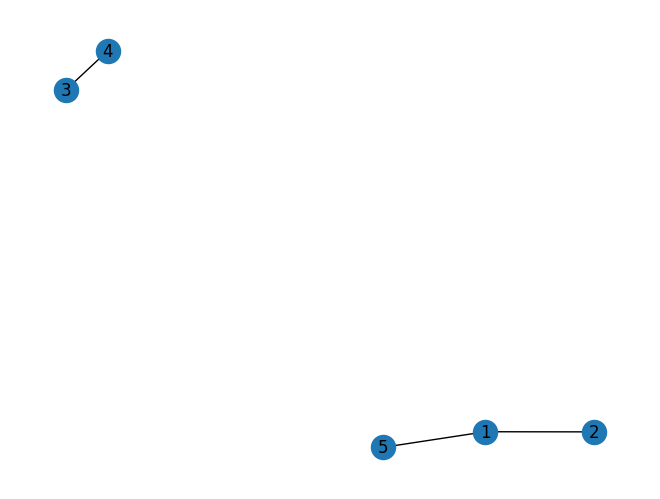

In [7]:
# Visualize Graph
def plot_graph(Graph):
    networkx.draw(Graph, with_labels=True)

plot_graph(Graph)

In [8]:
# Build graph in dictionary format, keys are nodes, values are the list of edges connected to each nodes
# graph naming convection for this format
def build_graph(V, E):
    return {i: [j for j in V if j!=i and (i, j) in E or (j, i) in E] for i in V}

graph = build_graph(V, E)
print(graph)

{1: [2, 5], 2: [1], 3: [4], 4: [3], 5: [1]}


Random graph generation

In [9]:
def generate_random_graph(n, k, r):
    """Set random seed to 'r' and create a graph with 'n' vertices and (up to) n * k edges."""
    random.seed(r)
    V = list(range(1,n+1))
    E = set()
    for _ in range(n*k):
        i = random.randint(1,n)
        j = random.randint(1,n)
        if i != j:
            i, j = min(i,j), max(i,j)
            E.add((i,j))
    return V, E

V, E = generate_random_graph(5, 1, 3)
print(f"V = {V}")
print(f"E = {E}")

V = [1, 2, 3, 4, 5]
E = {(4, 5), (2, 5), (3, 5), (1, 5)}


File management tools

In [10]:
def write_instance(V, E, filename):
    """Write a graph instance to a file (loosely, in a format used in DIMACS challenges)."""
    with open(filename, "w") as f:
        f.write(f"Nodes {n}\n")
        f.write(f"Edges {len(E)}\n")
        for (i,j) in E:
            f.write(f"E {i} {j}\n")

def read_instance(filename):
    """Read a graph from a file."""
    try:
        if len(filename)>3 and filename[-3:] == ".gz":  # file compressed with gzip
            import gzip
            f = gzip.open(filename, "rt")
        else:   # usual, uncompressed file
            f = open(filename)
    except IOError:
        print("could not open file", filename)
        exit(-1)

    edges = set()
    for line in f:
        if line[0:6].lower() == 'edges ':
            e, n_edges = line.split()
            n_edges = int(n_edges)
        elif line[0:6].lower() == 'nodes ':
            e, n_nodes = line.split()
            n_nodes = int(n_nodes)
        elif line[0:2].lower() == 'e ':
            e, i, j = line.split()
            i, j = int(i), int(j)
            i, j = min(i,j), max(i,j)
            edges.add((i,j))
    f.close()

    assert n_edges == len(edges)
    vertices = list(range(1,n_nodes+1))
    return vertices, list(edges)

Generate random graphs using predefined random seeds and write them to files

In [11]:
#for n in [100, 1000, 10000, 100000, 1000000]:
#    for k in [1, 2, 5, 10]:
#        for r in range(1,11):
#            V, E = generate_random_graph(n, k, r)
#            filename = f"graphs/G{n}-{k}-{r}.graph"
#            write_instance(V, E, filename)

networkx method for finding the number of connected components in a graph

In [12]:
def default_method(V, E):
    G = networkx.Graph()
    G.add_nodes_from(V)
    G.add_edges_from(E)
    return len(list(networkx.connected_components(G)))

# graph visulized previously
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]
print(build_graph(V, E))
print(f"no. of connected components: {default_method(V,E)}")

{1: [2, 5], 2: [1], 3: [4], 4: [3], 5: [1]}
no. of connected components: 2


Alternative method for finding the number of connected components in a graph

In [13]:
class my_no_connected_components:
    def __init__(self, g):
        self.g = g
        self.visited = {}
        self.V = g.keys()
        self.ncc = 0
        for k in self.V:
            self.visited[k] = self.visited.get(k, False)

    def find(self):
        for k in self.V:
            if self.visited[k] == False:
                self.dfs(k)
                self.ncc+=1
        return self.ncc

    def dfs(self, k):
        self.visited[k] = True
        for p in self.g[k]:
            if self.visited[p] == False:
                self.dfs(p)

def alternative_method(V, E):
    return my_no_connected_components(build_graph(V,E)).find()

# graph visulized previously
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]
print(build_graph(V, E))
print(f"no. of connected components: {alternative_method(V,E)}")

{1: [2, 5], 2: [1], 3: [4], 4: [3], 5: [1]}
no. of connected components: 2


Read graphs from files and solving them using both the default method and the alternative method, computing the cpu seconds, and writing that comparison data to files

In [14]:
#for n in [1000, 10000, 100000]:
#  with open(f"results_{n}.txt", "w") as f:
#    f.write(f"{'method':>12} {'nV':>8} {'nE':>9} {'ncc':>9} {'cpu_seconds':>10}\n")
#    for k in [1, 2, 5, 10]:
#        for r in range(1,11):
#            # read graph from file
#            graph_filename = f"graphs/G{n}-{k}-{r}.graph"
#            #graph_filename = '/content/drive/My Drive/' + f"graphs/G{n}-{k}-{r}.graph"
#            V, E = read_instance(graph_filename)
#
#            # defult method
#            start = time.process_time()
#            ncomponents_default = default_method(V,E)
#            end = time.process_time()
#            cpu_default = end - start
#            print(f"{graph_filename}: {ncomponents_default} components, {cpu_default} seconds")
#            f.write(f"{'default':>12} {len(V):>8} {len(E):>9} {ncomponents_default:>9} {cpu_default:>10}\n")
#            # alternative method
#            start = time.process_time()
#            ncomponents_alternative = alternative_method(V,E)
#            end = time.process_time()
#            cpu_alternative = end - start
#            print(f"{graph_filename}: {ncomponents_alternative} components, {cpu_alternative} seconds")
#            f.write(f"{'alternative':>12} {len(V):>8} {len(E):>9} {ncomponents_alternative:>9} {cpu_alternative:>10}\n")
#
#            if ncomponents_default != ncomponents_alternative:
#                print("Error")
#                exit(-1)
#
#

Analyse the data

In [15]:
#data = numpy.loadtxt('results_100.txt', skiprows=1, usecols=[i for i in range(5) if i not in [0]])
#data = data.transpose()
#data_default = data[:, ::2]
#data_alternative = data[:, 1::2]
#ncc_default = data_default[2]
#ncc_alternative = data_alternative[2]
#cpu_default = data_default[3]
#cpu_alternative = data_alternative[3]

In [16]:
#plt.title("#V = 100")
#plt.xlabel('#connected components')
#plt.ylabel('cpu seconds')
#plt.plot(ncc_default, cpu_default, '.')
#plt.plot(ncc_alternative, cpu_alternative, '.')
#plt.savefig('nV_100.png')

Algorithm implimentation in C

In [17]:
V = [1, 2, 3, 4, 5]
E = [(1, 2), (3, 4), (1, 5)]
print(V)

so_file = "/home/hugens/cc/taia/my_functions.so"
my_functions = ctypes.CDLL(so_file)

# convert python list to a c list
V_c = (ctypes.c_int * len(V))(*V)
# convert python tuple list to a c tuple list
class CTuple(ctypes.Structure):
    _fields_ = [("first", ctypes.c_int),
                ("second", ctypes.c_int)]

E_c = (CTuple * len(E))()

for i, (first, second) in enumerate(E):
    E_c[i].first = first
    E_c[i].second = second

# call the alternative method implemented in C
my_functions.my_no_connected_components(V_c, len(V), E_c, len(E))

[1, 2, 3, 4, 5]


2

In [18]:
import ctypes
so_file = "/home/hugens/cc/taia/my_functions.so"
my_functions = ctypes.CDLL(so_file)
class CTuple(ctypes.Structure):
        _fields_ = [("first", ctypes.c_int),
                    ("second", ctypes.c_int)]
    
def alternative_method_c(V, E):
    # convert list and tuple list to c versions
    V_c = (ctypes.c_int * len(V))(*V)
    E_c = (CTuple * len(E))(*E)
    for i, (first, second) in enumerate(E):
        E_c[i].first = first
        E_c[i].second = second

    return my_functions.my_no_connected_components(V_c, len(V), E_c, len(E))

In [ ]:
for n in [100, 1000, 10000, 100000, 1000000]:
  with open(f"results_c_{n}.txt", "w") as f:
    f.write(f"{'method':>12} {'nV':>8} {'nE':>9} {'ncc':>9} {'cpu_seconds':>10}\n")
    for k in [1, 2, 5, 10]:
        for r in range(1,11):
            # read graph from file
            graph_filename = f"graphs/G{n}-{k}-{r}.graph"
            #graph_filename = '/content/drive/My Drive/' + f"graphs/G{n}-{k}-{r}.graph"
            V, E = read_instance(graph_filename)

            # defult method
            start = time.process_time()
            ncomponents_default = default_method(V,E)
            end = time.process_time()
            cpu_default = end - start
            print(f"{graph_filename}: {ncomponents_default} components, {cpu_default} seconds")
            f.write(f"{'default':>12} {len(V):>8} {len(E):>9} {ncomponents_default:>9} {cpu_default:>10}\n")
            # alternative method
            start = time.process_time()
            ncomponents_alternative_c = alternative_method_c(V,E)
            end = time.process_time()
            cpu_alternative_c = end - start
            print(f"{graph_filename}: {ncomponents_alternative_c} components, {cpu_alternative_c} seconds")
            f.write(f"{'alternative':>12} {len(V):>8} {len(E):>9} {ncomponents_alternative_c:>9} {cpu_alternative_c:>10}\n")

            if ncomponents_default != ncomponents_alternative_c:
                print("Error")
                exit(-1)



graphs/G100-1-1.graph: 13 components, 0.0003807220000000555 seconds
graphs/G100-1-1.graph: 13 components, 0.0002540689999999124 seconds
graphs/G100-1-2.graph: 14 components, 0.00023524800000007673 seconds
graphs/G100-1-2.graph: 14 components, 0.00015651299999985824 seconds
graphs/G100-1-3.graph: 20 components, 0.0001909019999999373 seconds
graphs/G100-1-3.graph: 20 components, 0.0002223099999998368 seconds
graphs/G100-1-4.graph: 18 components, 0.00020108700000021074 seconds
graphs/G100-1-4.graph: 18 components, 0.0001533619999998237 seconds
graphs/G100-1-5.graph: 18 components, 0.00030864600000013453 seconds
graphs/G100-1-5.graph: 18 components, 0.0002331710000000875 seconds
graphs/G100-1-6.graph: 18 components, 0.00019326299999988805 seconds
graphs/G100-1-6.graph: 18 components, 0.0001621300000000936 seconds
graphs/G100-1-7.graph: 17 components, 0.00019321400000027467 seconds
graphs/G100-1-7.graph: 17 components, 0.00015201099999995193 seconds
graphs/G100-1-8.graph: 19 components, 0.0